In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Paths to your datasets
train_low_res_dir = '/content/drive/MyDrive/AI/Term 3/dataset/train/low_res'
train_high_res_dir = '/content/drive/MyDrive/AI/Term 3/dataset/train/high_res'
val_low_res_dir = '/content/drive/MyDrive/AI/Term 3/dataset/val/low_res'
val_high_res_dir = '/content/drive/MyDrive/AI/Term 3/dataset/val/high_res'

# Verify the number of images in each directory
print(f"Number of training low-res images: {len(os.listdir(train_low_res_dir))}")
print(f"Number of training high-res images: {len(os.listdir(train_high_res_dir))}")
print(f"Number of validation low-res images: {len(os.listdir(val_low_res_dir))}")
print(f"Number of validation high-res images: {len(os.listdir(val_high_res_dir))}")

class ImageEnhancementDataset(Dataset):
    def __init__(self, low_res_dir, high_res_dir, transform=None):
        self.low_res_dir = low_res_dir
        self.high_res_dir = high_res_dir
        self.transform = transform
        self.low_res_images = sorted(os.listdir(low_res_dir))
        self.high_res_images = sorted(os.listdir(high_res_dir))
        self.length = min(len(self.low_res_images), len(self.high_res_images))  # Ensure same length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        low_res_path = os.path.join(self.low_res_dir, self.low_res_images[idx])
        high_res_path = os.path.join(self.high_res_dir, self.high_res_images[idx])

        low_res_image = Image.open(low_res_path).convert('RGB')
        high_res_image = Image.open(high_res_path).convert('RGB')

        if self.transform:
            low_res_image = self.transform(low_res_image)
            high_res_image = self.transform(high_res_image)

        return low_res_image, high_res_image

# Define transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert PIL image to tensor
])

# Create datasets
train_dataset = ImageEnhancementDataset(train_low_res_dir, train_high_res_dir, transform=transform)
val_dataset = ImageEnhancementDataset(val_low_res_dir, val_high_res_dir, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


Number of training low-res images: 695
Number of training high-res images: 685
Number of validation low-res images: 170
Number of validation high-res images: 170


In [ ]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )
        self.skip_conv = nn.Conv2d(3, 3, kernel_size=1)

    def forward(self, x):
        skip = self.skip_conv(x)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x + skip
        return x

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(weights='IMAGENET1K_V1').features[:16].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        output_features = self.vgg(output)
        target_features = self.vgg(target)
        return self.mse(output_features, target_features)


In [ ]:

def train(model, loader, criterion, perceptual_criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        mse_loss = criterion(outputs, targets)
        perceptual_loss = perceptual_criterion(outputs, targets)
        loss = mse_loss + 0.1 * perceptual_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedCNN().to(device)
criterion = nn.MSELoss()
perceptual_criterion = PerceptualLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 25
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, perceptual_criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

model_save_path = '/content/drive/MyDrive/AI/Term 3/enhanced_image_model.pth'
torch.save(model.state_dict(), model_save_path)


NameError: name 'EnhancedCNN' is not defined

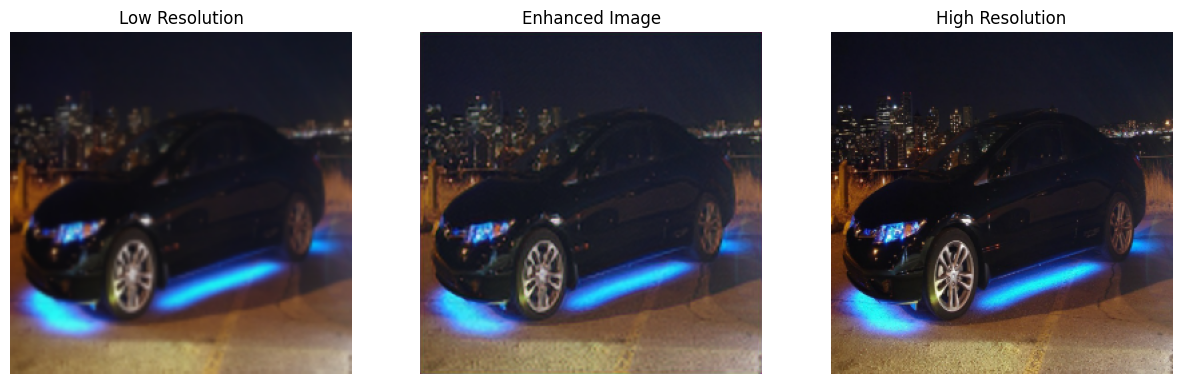

In [ ]:
# Load the saved model
loaded_model = EnhancedCNN()
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.to(device)
loaded_model.eval()

def test_model(model, loader, device):
    model.eval()
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = torch.clamp(outputs, 0, 1)

            # Move the tensors to CPU and convert to numpy arrays
            inputs = inputs.cpu().numpy().transpose((0, 2, 3, 1))
            targets = targets.cpu().numpy().transpose((0, 2, 3, 1))
            outputs = outputs.cpu().numpy().transpose((0, 2, 3, 1))

            # Display the first image in the batch
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(inputs[0])
            axes[0].set_title('Low Resolution')
            axes[0].axis('off')

            axes[1].imshow(outputs[0])
            axes[1].set_title('Enhanced Image')
            axes[1].axis('off')

            axes[2].imshow(targets[0])
            axes[2].set_title('High Resolution')
            axes[2].axis('off')

            plt.show()
            break  # Only display the first batch

test_model(loaded_model, val_loader, device)


In [ ]:
pip install scikit-image


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def calculate_metrics(output, target):
    output = output.cpu().numpy().transpose((0, 2, 3, 1))
    target = target.cpu().numpy().transpose((0, 2, 3, 1))

    psnr_values = []
    ssim_values = []

    for i in range(output.shape[0]):
        psnr_value = psnr(target[i], output[i], data_range=1.0)
        ssim_value, _ = ssim(target[i], output[i], data_range=1.0, multichannel=True, full=True)
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

    return np.mean(psnr_values), np.mean(ssim_values)



In [ ]:
def evaluate_model(model, loader, device):
    model.eval()
    total_psnr = 0
    total_ssim = 0
    count = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = torch.clamp(outputs, 0, 1)

            batch_psnr, batch_ssim = calculate_metrics(outputs, targets)
            total_psnr += batch_psnr * inputs.size(0)
            total_ssim += batch_ssim * inputs.size(0)
            count += inputs.size(0)

    avg_psnr = total_psnr / count
    avg_ssim = total_ssim / count

    print(f'Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}')
    return avg_psnr, avg_ssim


<ipython-input-9-b9cdeb8864b8>:13: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value, _ = ssim(target[i], output[i], data_range=1.0, multichannel=True, full=True)


Average PSNR: 27.1263, Average SSIM: 0.8771


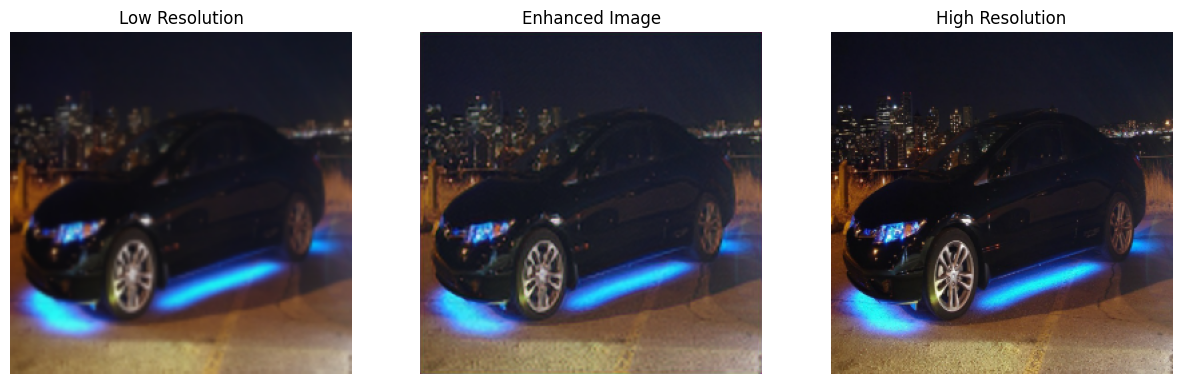

In [ ]:
def visualize_results(model, loader, device):
    model.eval()
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = torch.clamp(outputs, 0, 1)

            # Move the tensors to CPU and convert to numpy arrays
            inputs = inputs.cpu().numpy().transpose((0, 2, 3, 1))
            targets = targets.cpu().numpy().transpose((0, 2, 3, 1))
            outputs = outputs.cpu().numpy().transpose((0, 2, 3, 1))

            # Display the first image in the batch
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(inputs[0])
            axes[0].set_title('Low Resolution')
            axes[0].axis('off')

            axes[1].imshow(outputs[0])
            axes[1].set_title('Enhanced Image')
            axes[1].axis('off')

            axes[2].imshow(targets[0])
            axes[2].set_title('High Resolution')
            axes[2].axis('off')

            plt.show()
            break  # Only display the first batch

# Evaluate the model on the validation set
avg_psnr, avg_ssim = evaluate_model(loaded_model, val_loader, device)

# Visualize the results
visualize_results(loaded_model, val_loader, device)


<ipython-input-9-b9cdeb8864b8>:13: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value, _ = ssim(target[i], output[i], data_range=1.0, multichannel=True, full=True)


Average PSNR: 27.1263, Average SSIM: 0.8771


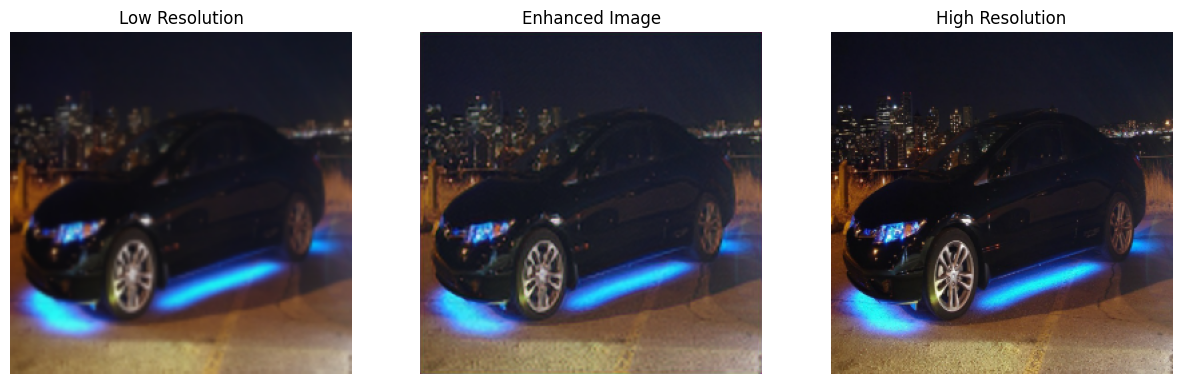

In [ ]:
# Evaluate the model
avg_psnr, avg_ssim = evaluate_model(loaded_model, val_loader, device)

# Visualize the results
visualize_results(loaded_model, val_loader, device)


In [ ]:
pip install torch torchvision scikit-image matplotlib


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg19
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Residual Block for Generator
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        return x + residual

# Generator
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_residual_blocks=16):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4)
        self.prelu = nn.PReLU()
        self.residual_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(num_residual_blocks)])
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        x = self.prelu(self.conv1(x))
        residual = x
        x = self.residual_blocks(x)
        x = self.bn2(self.conv2(x))
        x = x + residual
        x = self.conv3(x)
        return x

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        self.fc1 = nn.Linear(512 * 16 * 16, 1024)
        self.fc2 = nn.Linear(1024, 1)

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.conv_blocks(x)
        x = x.view(x.size(0), -1)
        x = self.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

# VGG Feature Extractor for Perceptual Loss
class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_layer=35):
        super(VGGFeatureExtractor, self).__init__()
        vgg = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg.features.children())[:feature_layer])

    def forward(self, x):
        return self.feature_extractor(x)


In [ ]:
def train_gan(generator, discriminator, feature_extractor, train_loader, optimizer_G, optimizer_D, criterion, perceptual_criterion, device):
    generator.train()
    discriminator.train()
    running_g_loss = 0.0
    running_d_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        outputs = generator(inputs)
        real_outputs = discriminator(targets)
        fake_outputs = discriminator(outputs.detach())
        d_loss_real = criterion(real_outputs, torch.ones_like(real_outputs))
        d_loss_fake = criterion(fake_outputs, torch.zeros_like(fake_outputs))
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_outputs = discriminator(outputs)
        g_loss_content = perceptual_criterion(feature_extractor(outputs), feature_extractor(targets))
        g_loss_adversarial = criterion(fake_outputs, torch.ones_like(fake_outputs))
        g_loss = g_loss_content + 1e-3 * g_loss_adversarial
        g_loss.backward()
        optimizer_G.step()

        running_g_loss += g_loss.item() * inputs.size(0)
        running_d_loss += d_loss.item() * inputs.size(0)

    epoch_g_loss = running_g_loss / len(train_loader.dataset)
    epoch_d_loss = running_d_loss / len(train_loader.dataset)
    return epoch_g_loss, epoch_d_loss

def validate_gan(generator, feature_extractor, val_loader, perceptual_criterion, device):
    generator.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = generator(inputs)
            loss = perceptual_criterion(feature_extractor(outputs), feature_extractor(targets))
            running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(val_loader.dataset)
    return epoch_loss

# Hyperparameters and Optimizers
lr = 1e-4
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator().to(device)
discriminator = Discriminator().to(device)
feature_extractor = VGGFeatureExtractor().to(device)
criterion = nn.BCEWithLogitsLoss()
perceptual_criterion = nn.MSELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Training Loop
for epoch in range(num_epochs):
    train_g_loss, train_d_loss = train_gan(generator, discriminator, feature_extractor, train_loader, optimizer_G, optimizer_D, criterion, perceptual_criterion, device)
    val_loss = validate_gan(generator, feature_extractor, val_loader, perceptual_criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Train G Loss: {train_g_loss:.4f}, Train D Loss: {train_d_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Optionally save the model after each epoch
    # torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
    # torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")
